#### Simulation Based Inference of the decay $B \to K^* \mu \mu$ with respect to the Wilson coefficient $C_9$
The observables of interest are $s = q^2$, $\theta_l$, $\theta_d$ and $\phi$.  

Notation in this notebook:  
Everything (parameters and data) is normalized except the objects labeled as "raw".  

### Part A: Useful objects

In [1]:
# imports
import torch
import eos
import sbi
import random
import numpy as np
import matplotlib.pyplot as plt

from sbi.utils import BoxUniform
from sbi.inference import NPE
from sbi.analysis import pairplot
from sbi.analysis import plot_summary
from sbi.diagnostics import run_sbc
from sbi.analysis.plot import sbc_rank_plot

In [2]:
# Simulator
class Simulator:
    # the simulator deals with un-normalized data (raw)
    def __init__(self, device, stride, pre_N, preruns, rng):
        self.device = device
        self.stride = stride
        self.pre_N = pre_N
        self.preruns = preruns
        self.rng = rng

        self.eos_kinematics = eos.Kinematics({
            's':             2.0,   's_min':             1,       's_max' :            8.0,
            'cos(theta_l)^LHCb':  0.0,  'cos(theta_l)^LHCb_min': -1.0,      'cos(theta_l)^LHCb_max': +1.0,
            'cos(theta_k)^LHCb':  0.0,  'cos(theta_k)^LHCb_min': -1.0,      'cos(theta_k)^LHCb_max': +1.0,
            'phi^LHCb':           0.3,  'phi^LHCb_min':           -1.0*np.pi,      'phi^LHCb_max':           1.0 * np.pi,
        })

        self.eos_options = eos.Options({
            'l': 'mu',
            'q': 'd',
            'model': 'WET',
            'debug': 'false',
            'logging': 'quiet',
            'log-level': 'off',
            
        })

        self.eos_parameters = eos.Parameters()
        
        self.distribution = eos.SignalPDF.make(
            'B->K^*ll::d^4Gamma@LowRecoil',
            self.eos_parameters, # arbitrary value
            self.eos_kinematics,
            self.eos_options
        )

    def to_tensor(self, x, dtype=torch.float32):
        return torch.as_tensor(x, dtype=dtype, device=self.device)

    def simulate_a_sample(self, raw_parameter, n_points):
        self.set_eos_parameter(raw_parameter)
        raw_sample, _ = self.distribution.sample_mcmc(
            N=n_points,
            stride=self.stride,
            pre_N=self.pre_N,
            preruns=self.preruns,
            rng=self.rng
        )
        return self.to_tensor(raw_sample)

    def simulate_samples(self, raw_parameters, n_points):
        n_samples = raw_parameters.shape[0]
        raw_data = torch.zeros((n_samples, n_points, self.point_dim), dtype=torch.float32, device=self.device)
        for i, raw_parameter in enumerate(raw_parameters):
            raw_data[i] = self.simulate_a_sample(raw_parameter, n_points)
        return raw_data

    def set_eos_parameter(self, raw_parameter):
        print("Hello", raw_parameter[0].item())
        self.eos_parameters.set("b->smumu::Re{c9}", raw_parameter[0].item())
        return self.eos_parameters

In [3]:
# Normalizer
class Normalizer:
    def __init__(self, raw_data, raw_parameters):
        self.data_mean = raw_data.mean(dim=(0,1)) # shape (point_dim) (on ne mélange pas q^2, phi,...)
        self.data_std = raw_data.std(dim=(0,1))
        self.parameters_mean = raw_parameters.mean(dim=0) # shape (parameter_dim)
        self.parameters_std = raw_parameters.std(dim=0)

    def normalize_data(self, raw_x):
        return (raw_x - self.data_mean) / self.data_std

    def denormalize_data(self, x):
        return x * self.data_std + self.data_mean
 
    def normalize_parameters(self, raw_parameters):
        return (raw_parameters - self.parameters_mean) / self.parameters_mean

    def denormalize_parameters(self, parameters):
        return parameters * self.parameters_std + self.parameters_mean

In [4]:
# Main entity
class SBI_C9:
    # Object containing everything we need
    def __init__(self, device, seed, stop_after_epochs):
        self.device = device
        self.rng = np.random.mtrand.RandomState(seed)
        self.stop_after_epochs = stop_after_epochs # souvent 20
        self.prior = None
        self.simulator = None
        self.normalizer = None
        # todo encoder
        self.neural_network = None
        self.posterior = None
        self.point_dim = 4
        self.parameters_dim = 1

    def to_tensor(self, x, dtype=torch.float32):
        return torch.as_tensor(x, dtype=dtype, device=self.device)

    def set_prior(self, raw_low, raw_high):
        # low and high are raw since the normalization has not been done yet when this function is called
        self.prior = BoxUniform(low=raw_low, high=raw_high, device=self.device)
        self.neural_network = NPE(prior=self.prior, device=self.device, density_estimator="nsf")

    def set_simulator(self, simulator):
        self.simulator = simulator

    def set_normalizer(self, normalizer):
        self.normalizer = normalizer

    def draw_raw_parameters_from_prior(self, n_parameters):
        return self.prior.sample((n_parameters,))
    
    def simulate_raw_data(self, n_samples, n_points): # used before creating the normalizer
        raw_parameters = self.draw_raw_parameters_from_prior(n_samples)
        return self.simulator.simulate_samples(raw_parameters, n_points), raw_parameters

    def simulate_data(self, n_samples, n_points):
        raw_data, raw_parameters = self.simulate_raw_data(n_samples, n_points)
        return self.normalizer.normalize_data(raw_data), self.normalizer.normalize_parameters(raw_parameters)
    
    def simulate_data_with_parameters(self, parameters, n_points):
        raw_parameters = self.normalizer.denormalize_parameters(parameters)
        raw_data = self.simulator.simulate_samples(raw_parameters, n_points)
        return self.normalizer.normalize_data(raw_data)

    def train(self, data, parameters):
        self.neural_network.append_simulations(parameters, data) # self.neural_network = ... ?
        self.neural_network.train(stop_after_epochs=self.stop_after_epochs)
        self.posterior = self.neural_network.build_posterior()

    # draw parameters from the posterior predicted for some observed sample
    def draw_parameters_from_predicted_posterior(self, observed_sample, n_parameters):
        return self.posterior.sample(n_parameters, x=observed_sample)

    # used to compare an observed sample with samples produced with parameters drawn from the posterior distribution predicted for the observed sample
    def simulate_data_from_predicted_posterior(self, observed_sample, n_samples):
        parameters = self.draw_parameters_from_predicted_posterior(observed_sample, n_samples)
        return self.simulate_data_with_parameters(parameters), parameters
    

In [5]:
# Ploter and Validator
class Ploter_Validator:
    # make cool plots and test the performance 
    axis_fontsize = 21 # companion object variables
    legend_fontsize = 15
    tick_fontsize = 15        

    @staticmethod
    def plot_a_sample(data, parameter):
        pass # todo

    # plot train and validation loss during last training
    @staticmethod
    def plot_loss(neural_network):
        _ = plot_summary(
            neural_network,
            tags=["training_loss", "validation_loss"],
            figsize=(10, 2),
        )

    @staticmethod
    def plot_a_posterior(sampled_parameters):
        pass# todo

    # plot data generated from parameters drawn from the posterior estimation associated with the observed sample
    @staticmethod
    def plot_similar_data(sbi_c9, observed_sample):
        pass# todo

    @staticmethod
    def do_sbc(sbi_c9):
        pass# todo 

    # todo do ppc, hdi and more tests 

### Part B: Actual inference

In [6]:
# Body
n_samples = 10
n_points = 10000 # points per sample

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 1
stop_after_epochs = 1
sbi_C9 = SBI_C9(device, seed, stop_after_epochs)

raw_low = sbi_C9.to_tensor([3])
raw_high = sbi_C9.to_tensor([5])
sbi_C9.set_prior(raw_low, raw_high)

stride = 1
pre_N = 200
preruns = 1
sbi_C9.set_simulator(Simulator(device, stride, pre_N, preruns, sbi_C9.rng))

raw_data, raw_parameters = sbi_C9.simulate_raw_data(n_samples, n_points)
sbi_C9.set_normalizer(Normalizer(raw_data, raw_parameters))
data = sbi_C9.normalizer.normalize_data(raw_data)
parameters = sbi_C9.normalizer.normalize_parameters(raw_parameters)

AttributeError: 'Simulator' object has no attribute 'point_dim'

For an interactive, detailed view of the summary, launch tensorboard  with 'tensorboard --logdir=/home/hep/nrc25/project/sbi/sbi-logs/NPE_C/2025-12-07T14_13_38.999254' from a terminal on your machine, visit http://127.0.0.1:6006 afterwards. Requires port forwarding if tensorboard runs on a remote machine, as e.g. https://stackoverflow.com/a/42445070/7770835 explains.

Valid tags are: ['best_validation_loss', 'epoch_durations_sec', 'epochs_trained', 'training_loss', 'validation_loss'].


 Neural network successfully converged after 2 epochs.

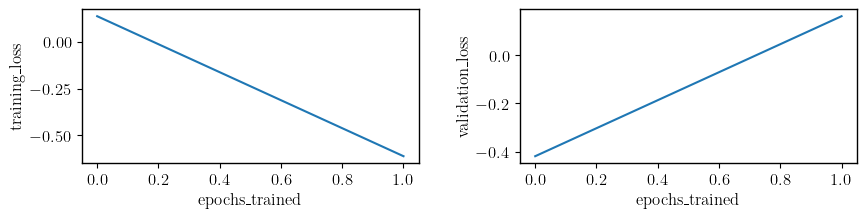

In [ ]:
sbi_C9.train(data[:,:,0], parameters) # pour l'instant une dimension de point (il faut fair encoder)
Ploter_Validator.plot_loss(sbi_C9.neural_network)